#### TELECOM CUSTOMER CHURN : DATA 428 PROJECT
# 4(B). Approach  2 : Pipeline - Using Yeo - Johnson Data

- Rest is same as No.4

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, neighbors, svm, calibration, tree, ensemble, cross_validation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
#not great but suppressess warning messages 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

#import pmlb

import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

sns.set(rc={"figure.figsize": (12, 8)})


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Using dataset with better column names

data = pd.read_csv("telecom_data_better_colnames.csv")

In [4]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
data.shape

(100000, 100)

In [6]:
# Checking the data types
#data.dtypes

## Data Wrangling - following issues to be addressed
    - 'geographic_area' : names can be made better to avoid errors (learnt after making mistakes initially)
    - drop rows with outliers 
    - drop columns with very high 'nan' / blanks
    - drop columns like 'child_between_0_to_2_years_in_house' 

In [7]:
data["geogrpahic_area"].unique()

array(['NORTHWEST/ROCKY MOUNTAIN AREA', 'CHICAGO AREA',
       'GREAT LAKES AREA', 'NEW ENGLAND AREA', 'DALLAS AREA',
       'CENTRAL/SOUTH TEXAS AREA', 'TENNESSEE AREA', 'MIDWEST AREA',
       'PHILADELPHIA AREA', 'OHIO AREA', 'HOUSTON AREA', 'SOUTHWEST AREA',
       'NEW YORK CITY AREA', 'ATLANTIC SOUTH AREA', 'SOUTH FLORIDA AREA',
       'CALIFORNIA NORTH AREA', 'DC/MARYLAND/VIRGINIA AREA',
       'NORTH FLORIDA AREA', nan, 'LOS ANGELES AREA'], dtype=object)

In [8]:
geo_area = []
for i in range(len(data)):
    item = data["geogrpahic_area"][i]
    #print(item)
    if type(item) is float:
        geo_area.append(item)
        #print(item)
    else:
        name = item.replace(' ', '_')
        name = name.replace('/', '_')
        geo_area.append(name)

In [9]:
data.drop("geogrpahic_area", inplace=True, axis=1)

In [10]:
data["geogrpahic_area"] = geo_area

In [11]:
data["geogrpahic_area"].unique()

array(['NORTHWEST_ROCKY_MOUNTAIN_AREA', 'CHICAGO_AREA',
       'GREAT_LAKES_AREA', 'NEW_ENGLAND_AREA', 'DALLAS_AREA',
       'CENTRAL_SOUTH_TEXAS_AREA', 'TENNESSEE_AREA', 'MIDWEST_AREA',
       'PHILADELPHIA_AREA', 'OHIO_AREA', 'HOUSTON_AREA', 'SOUTHWEST_AREA',
       'NEW_YORK_CITY_AREA', 'ATLANTIC_SOUTH_AREA', 'SOUTH_FLORIDA_AREA',
       'CALIFORNIA_NORTH_AREA', 'DC_MARYLAND_VIRGINIA_AREA',
       'NORTH_FLORIDA_AREA', nan, 'LOS_ANGELES_AREA'], dtype=object)

In [12]:
data.shape

(100000, 100)

#### no_of_unique_subscribers_in_the_house 
    - This feature has numeric discrete values and some outliers like 196 unique users in a house.
    - It's either a wrong entry or a 'close user group' (CUG) scenario of an organisation. 
    - Hence, dropping any entry with more than 20 subscribers in the house (making concessions for a hostel)

In [13]:
data['no_of_unique_subscribers_in_the_house'].unique()

array([  2,   1,   3,   5,   4,   6,   7,   9,   8,  12,  11,  10,  13,
        18, 196], dtype=int64)

In [14]:
for i in range(len(data)): 
    
    value = data['no_of_unique_subscribers_in_the_house'][i]
       
    if value > 20:
        data.drop(data.index[i], inplace = True)   
data = data.reset_index()
data.drop('index', axis = 1, inplace=True)

#         no_of_unique_subscribers.append('low')
#     elif value > 2 and value < 7:
#         no_of_unique_subscribers.append('medium')
#     else:
#         no_of_unique_subscribers.append('high')

In [15]:
for i in range(len(data)): 
    
    value_2 = data['no_of_active_subscribers_in_house'][i]
       
    if value_2 > 20:
        data.drop(data.index[i], inplace = True)    
        
data = data.reset_index()
data.drop('index', axis = 1, inplace=True)   

In [16]:
data.shape

(99999, 100)

### Dropping features with large missing values
    - 'known_no_of_vehicles' - 49.3% values missing (refer the data exploration notebook)

In [17]:
data.drop('known_no_of_vehicles', inplace=True, axis = 1)

In [18]:
data.drop('cust_id', inplace=True, axis = 1)

### FEATURES WITH 'U'  : Assuming 'U' to be 'Unknown' or 'Missing Value'

    - new_cell_phone_user : 66.9% 'U' values, which are as good as missing values
    - dualband :  "Y", "N", "T", "U".  Where 'U' is only 0.02%

In [19]:
data.new_cell_phone_user.value_counts()

U    66913
Y    19301
N    13785
Name: new_cell_phone_user, dtype: int64

In [20]:
data.drop('new_cell_phone_user', inplace=True, axis = 1)

In [21]:
# Need to decide - what to do with 'U'

data.dualband.value_counts()

Y    72264
N    23196
T     4316
U      222
Name: dualband, dtype: int64

In [22]:
data['dualband'] = data['dualband'].str.replace('U','Y')

In [23]:
# need to decide what to do with 'UNKW'
data.handset_web_capability.value_counts()

WCMB    75732
WC      13843
UNKW      235
Name: handset_web_capability, dtype: int64

In [24]:
data['handset_web_capability'] = data['handset_web_capability'].str.replace('UNKW', 'WCMB')

In [25]:
# Need to decide what to do with 'U'
data.marital_status.value_counts()

U    37332
M    31052
S    17627
B     7116
A     5140
Name: marital_status, dtype: int64

### Dropping five columns of 'children in house' as data very sparse and not clear

In [26]:
list_of_children = ['child_0_to_2_yrs_in_house', 'child_3_to_5_yrs_in_house',
                   'child_6_to_10_yrs_in_house', 'child_11_to_15_yrs_in_house',
                   'child_16_to_17_yrs_in_house']

In [27]:
#redundant_unknown_features = ["truck_indicator", "rv_indicator", "foreign_travel_dummy_variable", "infobase_match"]

In [28]:
def drop_feature(drop_list):
    for feature in drop_list:
        data.drop(feature, inplace=True, axis = 1)

In [29]:
drop_feature(list_of_children)

In [30]:
data.shape

(99999, 92)

### Converting categories with less than 5% representation in the Dataset into 'others' category  to avoid 'near zero variance' problem.

#### Feature - credit_class_code

In [31]:
# To see the 54 categories in this feature
data.credit_class_code.unique()

# To see the count of each category ( in next step - clubbing all < 5% i.e., 5000 count into 'others')
#data.credit_class_code.value_counts()

array(['A', 'EA', 'C', 'B', 'BA', 'D', 'G', 'CA', 'I', 'AA', 'J', 'U',
       'Z', 'K', 'E', 'E4', 'W', 'DA', 'Y', 'CC', 'GA', 'D4', 'D5', 'H',
       'ZA', 'JF', 'B2', 'IF', 'Z1', 'O', 'M', 'L', 'U1', 'Z4', 'A2', 'V',
       'TP', 'EM', 'C2', 'C5', 'S', 'EC', 'Z5', 'D2', 'GY', 'ZY', 'E2',
       'A3', 'V1', 'EF', 'Z2', 'CY', 'P1', 'ZF'], dtype=object)

In [32]:
cat_required = ["AA", "A", "BA", "CA", "EA"]
cat_with_others = []

for i in range(len(data)):
    cat = data.credit_class_code[i]
    
    if cat in cat_required:
        cat_with_others.append(cat)
        
    if cat not in cat_required:
        cat_with_others.append("others")
    

In [33]:
data.credit_class_code = cat_with_others

In [34]:
data.credit_class_code.unique()

array(['A', 'EA', 'others', 'BA', 'CA', 'AA'], dtype=object)

#### Feature - ethnicity_roll_to_up_code : Same steps as above.

In [35]:
ethnicity_code = []
ethnicity_code_required = ["X", "P", "M", "R", "D", "B", "F"]

for i in range(len(data)):
    cat = data.ethnicity_roll_to_up_code[i]
    
    if cat in ethnicity_code_required:
        ethnicity_code.append("others")
        
    if cat not in ethnicity_code_required:
        ethnicity_code.append(cat)
        

In [36]:
data['ethnicity_roll_to_up_code'] = ethnicity_code

In [37]:
data['ethnicity_roll_to_up_code'].unique()

array(['N', 'Z', 'U', 'I', 'S', 'others', 'J', 'H', 'G', 'O', nan, 'C'],
      dtype=object)

In [38]:
data.shape

(99999, 92)

### Defining lists of different types of data in the dataset

numeric_but_cat_for_imputation = "no_of_unique_subscribers_in_the_house",
                                 "no_of_active_subscribers_in_house",
                                 "no_of_handsets_issued",
                                 "no_of_models_issued",
                                 "truck_indicator",
                                 "rv_indicator",
                                 "foreign_travel_dummy_variable", 
                                 "no_of_adults_in_house",
                                 "estimated_income",
                                 "length_of_residence"


In [39]:
numeric_df = data.corr()

In [40]:
list_numeric_cols = list(numeric_df.columns)
#data[list_numeric_cols].describe()

In [41]:
# Features which have '0' and '1' value

binary_features = ["truck_indicator", "rv_indicator", "foreign_travel_dummy_variable"]

In [42]:
numeric_but_cat_for_imputation = ["no_of_unique_subscribers_in_the_house",
                "no_of_active_subscribers_in_house",
                "no_of_handsets_issued",
                "no_of_models_issued",
                "estimated_income",
                "length_of_residence",
                "no_of_adults_in_house"]
len(numeric_but_cat_for_imputation)

7

In [43]:
numeric_features_set = set(list_numeric_cols) - set(binary_features) - set(numeric_but_cat_for_imputation)
numeric_features = list(numeric_features_set)
numeric_features = [c for c in data[numeric_features] if c not in ["churn"]]
len(numeric_features)

66

In [44]:
# Just to check
"foreign_travel_dummy_variable"  in numeric_features

False

In [45]:
categorical_features_set = set(list(data.columns)) - set(numeric_features) - set(binary_features) - set(numeric_but_cat_for_imputation)
categorical_features = list(categorical_features_set)
categorical_features = [c for c in data[categorical_features] if c not in ["churn"]]
len(categorical_features)

15

In [46]:
# just to check
"churn" in (categorical_features or numeric_features)

False

# CHOOSE Log OR Yeo-Johnson Transform below

#### For Log Transformation, continue with the following cells.
#### For Yeo-J Transofromation, you may skip the log transform and go ahead to next cells.

### Log Transformation of Numeric Data

In [83]:
data.to_csv('data_before_transform.csv')

In [85]:
# Not using the dataframe 'data' to preserve it's integrity.

data_before_transform = pd.read_csv('data_before_transform.csv')

In [86]:
data_before_transform.drop('Unnamed: 0', axis=1, inplace=True)

In [88]:
data_before_transform.shape

(99999, 92)

In [89]:
numeric_cols = [c for c in numeric_features if c not in ["churn"]]

In [244]:
numeric_df = data[numeric_cols]
numeric_df.head()

,avg_no_of_attempted_calls,avg_no_of_blocked_voice_calls,avg_no_of_attempted_voice_calls_placed,avg_total_mthly_recurring_charge,avg_unrounded_mins_of_outbound_wireless_to_wireless_voice_calls,no_of_days_of_current_equipment,avg_no_of_completed_data_calls,avg_mthly_rev_over_the_previous_three_months,avg_mthly_mins_over_the_previous_six_months,avg_no_of_peak_data_calls,...,current_handset_price,avg_no_of_inbound_wireless_to_wireless_voice_calls,avg_no_of_off_to_peak_voice_calls,avg_no_of_recieved_sms,avg_unrounded_mins_of_received_voice_calls,billing_adjusted_total_no_of_calls_over_the_life_of_the_cust,avg_no_of_blocked_data_calls,avg_no_of_unans_data_calls,percntg_change_in_mthly_rev_vs_previous_three_month_avg,avg_no_of_dropped_data_calls
0,52.333333,0.666667,52.333333,22.500,0.000000,NaN,0.0,30,322.0,0.0,...,149.98999,0.000000,24.000000,0.0,97.176667,1602,0.0,0.0,-18.9975,0.0
1,263.333333,1.000000,263.333333,37.425,24.216667,240.0,0.0,40,477.0,0.0,...,NaN,6.333333,157.000000,0.0,55.280000,14624,0.0,0.0,50.9875,0.0
2,9.000000,0.000000,9.000000,16.990,0.000000,1504.0,0.0,17,11.0,0.0,...,29.98999,0.000000,1.000000,0.0,0.000000,7888,0.0,0.0,0.0000,0.0
3,3.666667,0.000000,3.666667,38.000,0.256667,1812.0,0.0,38,50.0,0.0,...,29.98999,0.000000,3.666667,0.0,0.413333,1479,0.0,0.0,0.0000,0.0
4,222.333333,0.666667,222.333333,71.980,10.816667,434.0,0.0,55,586.0,0.0,...,149.98999,0.666667,90.333333,0.0,106.330000,4452,0.0,0.0,0.0000,0.0


#### Histograms - Same as Notebook No - 3

In [245]:
# numeric_df.hist(bins=12, figsize=(30,30))
# plt.savefig('Histograms of Numeric data.jpeg')

In [246]:
#numeric_df.describe().T

### Discarding Negative Value Columns - to apply Log Transform

In [247]:
positive_df = numeric_df.loc[:, numeric_df.min() >= 0]

In [248]:
len(positive_df.columns)

60

In [249]:
positive_df = np.log(positive_df + 0.01)
#positive_df.head()

In [250]:
# positive_df.hist(bins=12, figsize=(30,30))
# plt.savefig('Poistive_df Histograms of Numeric data.jpeg')

#### Creating a Dataset With Log of 61 Numeric Values for Building the Models

In [251]:
for features in positive_df:
    if features in data_before_transform:
        data_before_transform[features] = positive_df[features]

In [252]:
data_after_log = data_before_transform

In [253]:
data_after_log.shape

(99999, 92)

### Applying YEO-JOHNSON Transformation

In [255]:
# This One does not work on older versions of sklearn - Hence, did the transformation in a different machine.
# Just followed the example given in https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html

#from sklearn.preprocessing import PowerTransformer

#### Since the sklearn version didnot support PowerTransformer, Yeo_Johnson transformation was applied on another machine and data saved. Calling that data here

In [256]:
# Using dataset transformed and saved on a different machine

yeo_johnson_data_df = pd.read_csv("yeo_johnson_data_df.csv")

In [325]:
#yeo_johnson_data_df.drop('Unnamed: 0', axis=1, inplace=True)

In [326]:
yeo_johnson_data_df.shape

(99999, 66)

In [327]:
yeo_johnson_data_df.head(3)
# Need to get the column names in place before re-building the entire dataset

,avg_no_of_attempted_calls,avg_no_of_blocked_voice_calls,avg_no_of_attempted_voice_calls_placed,avg_total_mthly_recurring_charge,avg_unrounded_mins_of_outbound_wireless_to_wireless_voice_calls,no_of_days_of_current_equipment,avg_no_of_completed_data_calls,avg_mthly_rev_over_the_previous_three_months,avg_mthly_mins_over_the_previous_six_months,avg_no_of_peak_data_calls,...,current_handset_price,avg_no_of_inbound_wireless_to_wireless_voice_calls,avg_no_of_off_to_peak_voice_calls,avg_no_of_recieved_sms,avg_unrounded_mins_of_received_voice_calls,billing_adjusted_total_no_of_calls_over_the_life_of_the_cust,avg_no_of_blocked_data_calls,avg_no_of_unans_data_calls,percntg_change_in_mthly_rev_vs_previous_three_month_avg,avg_no_of_dropped_data_calls
0,-1.066156,0.826798,-0.328820,-0.448723,-0.209734,-1.547910,-0.069862,-1.052027,-0.413039,-1.206385,...,-0.677761,-1.240796,-0.140061,-0.415984,-0.518636,-0.219844,-0.741817,-0.454277,-0.325282,-0.185105
1,0.243078,NaN,0.929355,-0.448723,1.854992,0.525417,-0.069862,-0.076471,0.960921,0.842557,...,1.070984,0.309002,-0.140061,0.954359,1.862811,-0.219844,-0.299461,-0.267534,0.937005,1.211198
2,-1.535475,-1.250579,-1.320873,-0.448723,1.747181,-1.547910,-0.069862,-1.052027,-1.273309,0.114208,...,-0.677761,0.199245,-0.140061,-1.274621,0.077599,-0.219844,-1.592736,-0.977491,-1.319491,-1.505747


In [263]:
yeo_johnson_data_df.columns = list(numeric_df.columns)

In [264]:
yeo_johnson_data_df.head(3)

,avg_no_of_attempted_calls,avg_no_of_blocked_voice_calls,avg_no_of_attempted_voice_calls_placed,avg_total_mthly_recurring_charge,avg_unrounded_mins_of_outbound_wireless_to_wireless_voice_calls,no_of_days_of_current_equipment,avg_no_of_completed_data_calls,avg_mthly_rev_over_the_previous_three_months,avg_mthly_mins_over_the_previous_six_months,avg_no_of_peak_data_calls,...,current_handset_price,avg_no_of_inbound_wireless_to_wireless_voice_calls,avg_no_of_off_to_peak_voice_calls,avg_no_of_recieved_sms,avg_unrounded_mins_of_received_voice_calls,billing_adjusted_total_no_of_calls_over_the_life_of_the_cust,avg_no_of_blocked_data_calls,avg_no_of_unans_data_calls,percntg_change_in_mthly_rev_vs_previous_three_month_avg,avg_no_of_dropped_data_calls
0,-1.066156,0.826798,-0.328820,-0.448723,-0.209734,-1.547910,-0.069862,-1.052027,-0.413039,-1.206385,...,-0.677761,-1.240796,-0.140061,-0.415984,-0.518636,-0.219844,-0.741817,-0.454277,-0.325282,-0.185105
1,0.243078,NaN,0.929355,-0.448723,1.854992,0.525417,-0.069862,-0.076471,0.960921,0.842557,...,1.070984,0.309002,-0.140061,0.954359,1.862811,-0.219844,-0.299461,-0.267534,0.937005,1.211198
2,-1.535475,-1.250579,-1.320873,-0.448723,1.747181,-1.547910,-0.069862,-1.052027,-1.273309,0.114208,...,-0.677761,0.199245,-0.140061,-1.274621,0.077599,-0.219844,-1.592736,-0.977491,-1.319491,-1.505747


In [265]:
for features in yeo_johnson_data_df:
    if features in data_before_transform:
        data_before_transform[features] = yeo_johnson_data_df[features]

In [266]:
data_after_yeo_j = data_before_transform

In [267]:
#data_after_yeo_j.to_csv("data_after_yeo_j.csv")

## Now building the Pipeline for pre-processing and fitting of models

In [268]:
#  USING THE LOG TRANSFORMED DATA 

df = data_after_yeo_j                       #[0:30000]

In [269]:
df.shape

(99999, 92)

In [270]:
x_cols = [c for c in df if c not in ["churn"]]
len(x_cols)

91

In [271]:
X = df[x_cols]

In [272]:
X.shape

(99999, 91)

In [273]:
y = df["churn"]

### Ensuring correct data types

In [274]:
for f in binary_features:
    X[f] = X[f].astype("bool")


In [275]:

for f in categorical_features:
    X[f] = X[f].astype("category")

In [276]:
#Imputer(strategy="most_frequent")

In [277]:
for f in numeric_features:
    X[f] = X[f].astype("float64")

### SPLITTING : TRAIN - TEST DATA

In [278]:
# Partition data set into training/test split (4 to 1 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [279]:
X_train.shape

(79999, 91)

In [280]:
X_test.shape

(20000, 91)

In [281]:
X.shape

(99999, 91)

In [282]:
total = 0
for i in categorical_features:
    total += X[i].nunique()
    
total

84

In [283]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [284]:
ts = TypeSelector(np.number)
ts.fit_transform(X_train).head(3)

,avg_mthly_rev,avg_no_of_mthly_mins,avg_total_mthly_recurring_charge,avg_no_of_directory_assisted_calls,avg_overage_mins,avg_overage_rev,avg_rev_of_voice_overage,avg_rev_of_data_overage,avg_no_of_roaming_calls,percntg_change_in_mthly_mins_vs_previous_three_month_avg,...,avg_mthly_mins_over_the_previous_six_months,avg_mthly_no_of_calls_over_the_previous_six_months,avg_mthly_rev_over_the_previous_six_months,current_handset_price,no_of_handsets_issued,no_of_models_issued,length_of_residence,no_of_adults_in_house,estimated_income,no_of_days_of_current_equipment
46627,0.285321,-0.357941,-0.448723,0.310199,-0.046802,-0.068766,-0.220342,-0.126085,1.047673,0.488635,...,0.016209,-0.269299,0.126231,0.442942,1.0,1.0,15.0,5.0,5.0,0.397965
87075,-0.235895,-1.017613,1.956274,1.408359,-0.046802,1.420679,-0.220342,-0.126085,2.300193,1.394411,...,1.872175,-0.269299,1.727524,1.312857,1.0,1.0,NaN,NaN,NaN,1.796042
44847,0.711005,0.144838,-0.448723,0.970456,-0.046802,0.351975,-0.220342,-0.126085,-0.895122,0.992270,...,0.623581,-0.269299,0.251460,0.104107,1.0,1.0,6.0,3.0,2.0,1.047752


In [285]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        #print(columns)
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
            
# cs = ColumnSelector(columns=numeric_features)  #  ["state", "account length", "area code"])
# cs.fit_transform(df).head()

In [286]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mode',filler='NA'):
        self.strategy = strategy
        self.fill = filler

    def fit(self, X, y=None):
        if self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname,v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [287]:
# Made by Ravi

class CustomColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns= columns
        
    def fit(self,X, y=None):
        return self
    
    def transform(self,X,y=None):
        Y = pd.DataFrame()
        for i in self.columns:
            Y[i] = X[i]
        return Y

In [289]:
class create_dummies(BaseEstimator, TransformerMixin): 
    def __init__(self):
        print("transforming the data")
    
    def fit(self, X, y =None):
        return self

    
    def transform(self, X,y =None):
        assert isinstance(X,  pd.DataFrame)
        for i in X.columns:
            x = pd.get_dummies(X[i],drop_first=True,prefix_sep='_')
            X.drop(i, axis=1, inplace= True)
            X= pd.concat([X,x], axis=1)
            #print(X.shape)
        return X

In [290]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            CustomColumn(columns=numeric_features),
            Imputer(strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            CustomImputer(strategy="mode"),
            create_dummies()
            
        )),
        ("numeric_but_cat_for_imputation", make_pipeline(
            TypeSelector(np.number),
            CustomColumn(columns= numeric_but_cat_for_imputation),
            Imputer(strategy="most_frequent")
            #StandardScaler()
        )),
        ("binary_features", make_pipeline(
            TypeSelector("bool"),
            Imputer(strategy="most_frequent")
        ))
        ])
)

transforming the data


In [291]:
X_train.shape

(79999, 91)

In [292]:
x_train_transformed = preprocess_pipeline.fit_transform(X_train)
x_train_transformed

array([[-0.74,  0.83,  0.03, ...,  1.  ,  1.  ,  0.  ],
       [ 2.43, -0.21,  1.52, ...,  1.  ,  1.  ,  1.  ],
       [-0.52,  0.83,  0.69, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [-0.23,  0.83,  0.41, ...,  0.  ,  0.  ,  1.  ],
       [-0.29,  0.56, -0.57, ...,  0.  ,  0.  ,  0.  ],
       [ 0.14, -1.26, -0.43, ...,  0.  ,  0.  ,  0.  ]])

In [293]:
x_train_transformed.shape

(79999, 145)

In [294]:
x_test_transformed = preprocess_pipeline.transform(X_test)
x_test_transformed

array([[ 1.02,  0.12,  1.54, ...,  1.  ,  0.  ,  0.  ],
       [-0.12, -1.26, -1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 0.35,  0.56,  1.24, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [-0.71,  0.83, -1.09, ...,  0.  ,  0.  ,  0.  ],
       [ 0.12,  0.56,  0.65, ...,  1.  ,  1.  ,  0.  ],
       [-0.46,  0.83, -1.89, ...,  0.  ,  0.  ,  0.  ]])

In [295]:
x_test_transformed.shape

(20000, 145)

### Preprocessing Pipeline + Classifier + Grid Search

In [296]:

def plot_roc(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)

    # Plot ROC curve
    plt.figure(figsize=(16, 12))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
    plt.ylabel('True Positive Rate (Sensitivity)', size=16)
    plt.title('ROC Curve', size=20)
    plt.legend(fontsize=14);

In [297]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
class_names = data.churn

In [298]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

### RANDOM FOREST

In [172]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    RandomForestClassifier(bootstrap=True,n_jobs=-1)
)

In [299]:
param_grid = {
            "randomforestclassifier__n_estimators": [3000, 5000, 7000],
            'randomforestclassifier__max_features': ['sqrt', 'log2'],
            'randomforestclassifier__criterion': ['gini', 'entropy']
            }

classifier_model = GridSearchCV(classifier_pipeline,param_grid, cv=2)
classifier_model.fit(X_train, y_train)

transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['avg_mthly_rev', 'avg_no_of_mthly_mins', 'avg_total_mthly_recurring_charge', 'avg_no_of_directory_assisted_calls', 'avg_overage_mins', 'avg_overage_rev', 'avg_rev_of_voice_overage', 'avg_rev_of_data_over..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [3000, 5000, 7000], 'randomforestclassifier__max_features': ['sqrt', 'log2'], 'randomforestclassifier__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [300]:
classifier_model.grid_scores_, classifier_model.best_params_, classifier_model.best_score_

([mean: 0.62345, std: 0.00007, params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 3000},
  mean: 0.62491, std: 0.00018, params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 5000},
  mean: 0.62490, std: 0.00030, params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 7000},
  mean: 0.62313, std: 0.00042, params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 3000},
  mean: 0.62252, std: 0.00017, params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 5000},
  mean: 0.62313, std: 0.00009, params: {'randomforestclassifier__criterion': 'gini', 'randomforestcl

#### FITTING BEST RANDOM FOREST

In [301]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    RandomForestClassifier(bootstrap=True,n_jobs=-1, 
    criterion="entropy", max_features="sqrt", n_estimators=5000)
)

In [302]:
classifier_model = classifier_pipeline  #GridSearchCV(classifier_pipeline,param_grid, cv=2)
classifier_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['avg_mthly_rev', 'avg_no_of_mthly_mins', 'avg_total_mthly_recurring_charge', 'avg_no_of_directory_assisted_calls', 'avg_overage_mins', 'avg_overage_rev', 'avg_rev_of_voice_overage', 'avg_rev_of_data_over..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [303]:
y_pred = classifier_model.predict(X_test)

In [304]:
from sklearn import metrics

In [305]:
metrics.confusion_matrix(y_pred, y_test)

array([[6344, 3492],
       [3792, 6372]], dtype=int64)

In [306]:
# Best Random Forest Approach - 2
print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.63      0.64      0.64      9836
          1       0.65      0.63      0.64     10164

avg / total       0.64      0.64      0.64     20000



In [307]:
metrics.cohen_kappa_score(y_pred, y_test)

0.2717624261084808

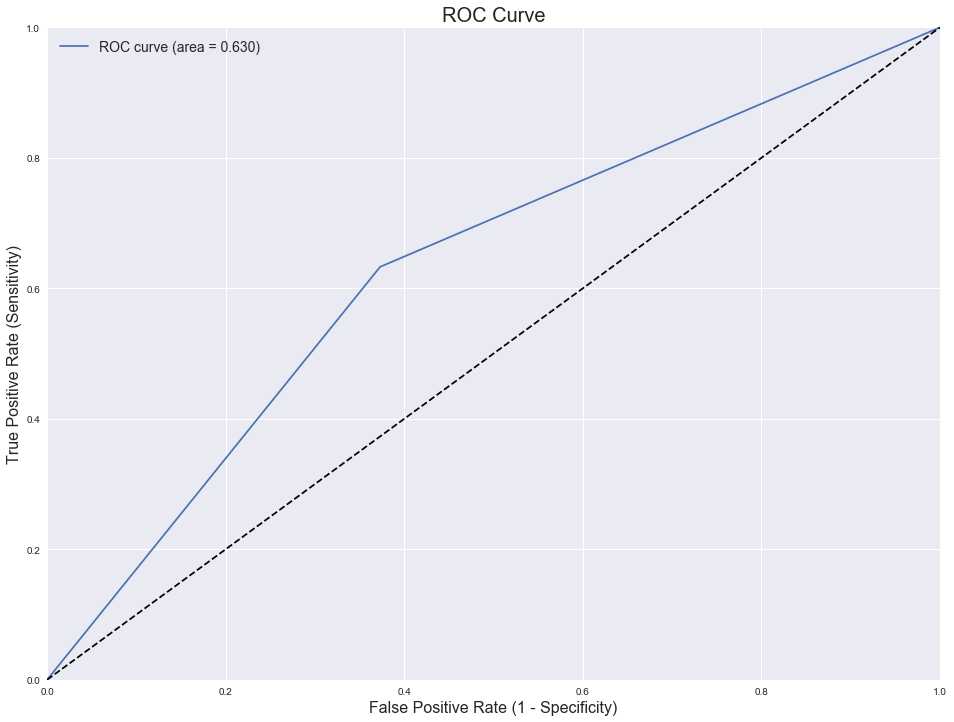

In [329]:
plot_roc(y_test, y_pred)

Normalized confusion matrix
[[0.63 0.37]
 [0.35 0.65]]


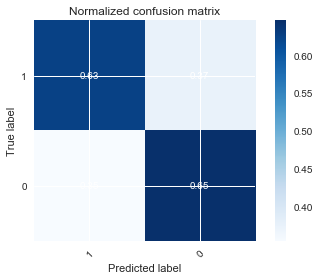

In [309]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

plt.show()

### ADA Boost

In [310]:
from sklearn.ensemble import AdaBoostClassifier

In [311]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    AdaBoostClassifier()
)

In [312]:
param_grid = {'adaboostclassifier__n_estimators': [50, 100, 250, 500],                                         
               'adaboostclassifier__learning_rate': [10 ** x for x in range(-3, 3)]}

classifier_model = GridSearchCV(classifier_pipeline,param_grid, cv=2)
classifier_model.fit(X_train, y_train)

transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transforming the data
transformi

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['avg_mthly_rev', 'avg_no_of_mthly_mins', 'avg_total_mthly_recurring_charge', 'avg_no_of_directory_assisted_calls', 'avg_overage_mins', 'avg_overage_rev', 'avg_rev_of_voice_overage', 'avg_rev_of_data_over...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'adaboostclassifier__n_estimators': [50, 100, 250, 500], 'adaboostclassifier__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [313]:
classifier_model.grid_scores_, classifier_model.best_params_, classifier_model.best_score_

([mean: 0.58042, std: 0.00021, params: {'adaboostclassifier__learning_rate': 0.001, 'adaboostclassifier__n_estimators': 50},
  mean: 0.58042, std: 0.00021, params: {'adaboostclassifier__learning_rate': 0.001, 'adaboostclassifier__n_estimators': 100},
  mean: 0.58042, std: 0.00021, params: {'adaboostclassifier__learning_rate': 0.001, 'adaboostclassifier__n_estimators': 250},
  mean: 0.57907, std: 0.00156, params: {'adaboostclassifier__learning_rate': 0.001, 'adaboostclassifier__n_estimators': 500},
  mean: 0.57907, std: 0.00156, params: {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 50},
  mean: 0.57804, std: 0.00053, params: {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 100},
  mean: 0.58016, std: 0.00028, params: {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 250},
  mean: 0.58144, std: 0.00023, params: {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 500}

In [314]:
y_pred = classifier_model.predict(X_test)

### Best ADA BOOST

In [315]:
from sklearn import metrics

In [316]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    AdaBoostClassifier(learning_rate=1, n_estimators=250)
)

In [317]:
classifier_model = classifier_pipeline  #GridSearchCV(classifier_pipeline,param_grid, cv=2)
classifier_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['avg_mthly_rev', 'avg_no_of_mthly_mins', 'avg_total_mthly_recurring_charge', 'avg_no_of_directory_assisted_calls', 'avg_overage_mins', 'avg_overage_rev', 'avg_rev_of_voice_overage', 'avg_rev_of_data_over...hm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=250, random_state=None))])

In [318]:
y_pred = classifier_model.predict(X_test)

In [319]:
from sklearn import metrics

In [320]:
metrics.confusion_matrix(y_pred, y_test)

array([[6356, 3621],
       [3780, 6243]], dtype=int64)

In [321]:
# Best ADA Boost Appraoch - 2
print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.63      0.64      0.63      9977
          1       0.63      0.62      0.63     10023

avg / total       0.63      0.63      0.63     20000



In [322]:
metrics.cohen_kappa_score(y_pred, y_test)

0.2599231496038804

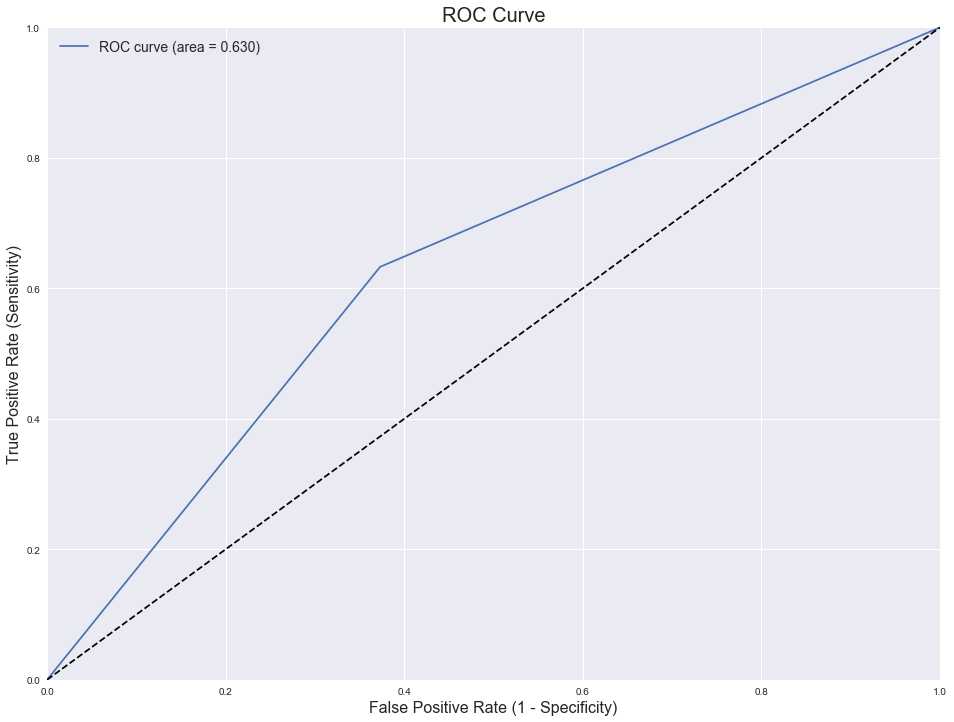

In [323]:
plot_roc(y_test, y_pred)

Normalized confusion matrix
[[0.63 0.37]
 [0.37 0.63]]


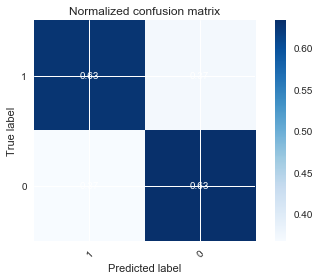

In [324]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

plt.show()

### GAUSSIAN PROCESS CLASSIFIER - DOES NOT EXEUTE FOR SUCH LARGE DATA 
- IT turns the data into a matrix of 99,999 x 99,999 : the processor runs out of memory

   ### Gaussian Process Classifier

In [159]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [160]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))

In [ ]:
(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, max_iter_predict=100, warm_start=False, 
copy_X_train=True, random_state=None, multi_class= 'one_vs_rest' , n_jobs=1)

In [228]:
param_grid = {'gaussianprocessclassifier_n_restarts_optimizer' : [3,5, 10]}
             #'gaussianprocessclassifier_copy_X_train' : [False]

In [229]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    GaussianProcessClassifier(kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)))                # kernel=kernel, n_restarts_optimizer=15
)

In [230]:
#param_grid = {}

classifier_model = GridSearchCV(classifier_pipeline, param_grid = param_grid, cv=2) #param_grid,
classifier_model.fit(X_train, y_train)

transforming the data
transforming the data


ValueError: Invalid parameter gaussianprocessclassifier_n_restarts_optimizer for estimator Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['avg_mthly_rev', 'avg_no_of_mthly_mins', 'avg_total_mthly_recurring_charge', 'avg_no_of_directory_assisted_calls', 'avg_overage_mins', 'avg_overage_rev', 'avg_rev_of_voice_overage', 'avg_rev_of_data_over...mizer=0,
             optimizer='fmin_l_bfgs_b', random_state=None,
             warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

### No 4 Notebook Ends Here